This notebook is for the purposes of graphing the Virgo Cluster against the CC/cooling flow approximations.

In [1]:
import random
import statistics
import matplotlib.pyplot as plt
import numpy as np
#from scipy.integrate import odeint
#from scipy.stats import linregress
from scipy.interpolate import interp1d
from scipy.integrate import solve_ivp
from scipy.constants import k as k_B  # Boltzmann constant in J/K
from scipy.constants import G, proton_mass
from functools import partial
import lab_functions_1 as lf
from numba import njit
mp_g = proton_mass*1e3
k_Bcgs = k_B*1e7
mu = 0.593
gamma = 5/3
ktc = 3.0857e21
etkv = 6.2415*10**8
kevtk = 1.16*10**7
z = 0.004
Mdot1 = 6.30391e25

In [2]:
radii_grid = np.linspace(0.1*ktc, 20000*ktc, 75000)
vc_grid = np.array([lf.vcgrab(r, z, 1e12, 1.2e15) for r in radii_grid])
vc_interp = interp1d(radii_grid, vc_grid, kind='cubic', fill_value='extrapolate')

In [3]:
from scipy.integrate import cumulative_trapezoid
r_grid = np.geomspace(ktc*0.001, 28518000 * ktc, 20000)  # finer grid = better accuracy
vc2_over_r = np.array([(lf.vcgrab(r, z, 1e12, 1.2e15)**2 / r) for r in r_grid])

phi_cumint = cumulative_trapezoid(vc2_over_r, r_grid, initial=0.0)

phi_values = -(phi_cumint[-1] - phi_cumint)

phi_interp = interp1d(r_grid, phi_values, kind='cubic', fill_value="extrapolate")

def phi(r):
    """Interpolated gravitational potential at any r."""
    return phi_interp(r)

In [4]:
@njit
def compute_dvdr_dTdr(v, T, r, Mdot, vc2, Lambda):
    cs2 = (gamma * k_Bcgs * T) / (mu * mp_g)
    if cs2 == 0:
        print(T)
    tflow = r / abs(v)
    mach2 = v**2 / cs2
    rho = Mdot / (4 * np.pi * r**2 * v)
    n = rho / (mu * mp_g)
    tcool = (3 * k_Bcgs * T) / (2 * Lambda * n)

    dlnvdlnr = (2 - (vc2 / cs2) - (tflow / (gamma * tcool))) / (mach2 - 1.0)
    dlnTdlnr = (tflow / tcool) - (2 / 3) * (2 + dlnvdlnr)

    dvdr = (v / r) * dlnvdlnr
    dTdr = (T / r) * dlnTdlnr

    return dvdr, dTdr

In [5]:
# THE ODE SOLVER ITSELF
def TheODE(r, C, Mdot, Lambdatype, recorder=None):
    v, T = C
    vc2 = vc_interp(r)**2

    # n is computed inside, so use dummy rho/n for Lambda
    rho = Mdot / (4 * np.pi * r**2 * v)
    n = rho / (mu * mp_g)
    Lambda = lf.Lambdacalc(np.log10(T), r, Lambdatype, n)

    # if T > 10**8.16:
    #     print(T)
    dvdr, dTdr = compute_dvdr_dTdr(v, T, r, Mdot, vc2, Lambda)

    if recorder is not None:
        recorder["ra2"].append(r)
        recorder["varray"].append(v)
        recorder["Tarray"].append(T)
        recorder["rhoarray"].append(rho)
        cs2 = (gamma * k_Bcgs * T) / (mu * mp_g)  
        Bern = (v**2 / 2) + (cs2 * 3 / 2) + phi(r)
        recorder["Bern"].append(Bern)
        mach = np.sqrt(v**2 / abs(cs2))
        recorder["Mach"].append(mach)
    return [dvdr, dTdr]

In [6]:
# CLASSES (THE BANE OF MY EXISTENCE)
class IntegrationResult:
    def __init__(self, res, stop_reason, xval=None, R0=None, v0=None, T0=None, Mdot=None):
        self.res = res
        self._stop_reason = stop_reason
        self.xval = xval
        self.R0 = R0
        self.v0 = v0
        self.T0 = T0
    
    def stopReason(self):
        return self._stop_reason
    
    def Rs(self):
        return self.res.t
    
    def __getitem__(self, key):
        return self.res[key]


# EVENTS LIST
def event_unbound(r, C, Mdot, Lambdatype, _):
    v, T = C
    cs2 = (gamma * k_Bcgs * T) / (mu * mp_g)
    phi_r = phi(r)
    bern = 0.5 * v**2 + 1.5 * cs2 + phi_r
    return bern
event_unbound.terminal = True
event_unbound.direction = 1

def event_lowT(r, C, Mdot, Lambdatype, _):
    T = C[1]
    return T - (10**4.2)
event_lowT.terminal = True
event_lowT.direction = -1 

def event_sonic_point(r, C, Mdot, Lambdatype, _):
    v, T = C
    cs2 = (gamma * k_Bcgs * T) / (mu * mp_g)
    mach = v / np.sqrt(cs2)
    return mach - 1.0
event_sonic_point.terminal = True
event_sonic_point.direction = -1

def event_max_R(r, C, Mdot, Lambdatype, _):
    v, T = C
    return r - (20000*ktc)
event_max_R.terminal = True
event_max_R.direction = 1

def event_overstepdlnv(r, C, Mdot, Lambdatype, _):
    v, T = C

    vc2 = vc_interp(r)**2
    cs2 = (gamma * k_Bcgs * T) / (mu * mp_g)
    
    tflow = r / np.abs(v)
    mach = v / np.sqrt(cs2)

    rho = Mdot / (4 * np.pi * r**2 * v)
    n = rho / (mu * mp_g)
    Lambda = lf.Lambdacalc(np.log10(T), r, Lambdatype, n)
    
    tcool = (3 * k_Bcgs * T) / (2 * Lambda * n)

    dlnvdlnr = (2 - (vc2 / cs2) - (tflow/ (gamma*tcool))) / (mach**2 - 1.0)
    return np.abs(dlnvdlnr) - 50
event_overstepdlnv.terminal = True
event_overstepdlnv.direction = 1 

my_event_list = [
    event_sonic_point,
    event_unbound,
    event_lowT,
    event_max_R,
    event_overstepdlnv
]


event_names = ['sonic point', 'unbound', 'lowT', 'max R reached', 'overstepdlnv' ]

# SHOOTING METHOD
def sonic_point_shooting(Rsonic, Lambdatype, Rmax=20000*ktc, tol=1e-8, epsilon=1e-5, dlnMdlnRInit=-1, x_high=10, x_low=1e-5, return_all_results=False):
    results = {}
    dlnMdlnRold = dlnMdlnRInit
    
    # x = v_c / 2*c_s is the iterative variable
    while x_high - x_low > tol:
        #INITIAL GUESSES
        x = 0.5 * (x_high + x_low)
        #print(x)
        cs2_sonic = vc_interp(Rsonic)**2 / (2 * x)
        v_sonic = cs2_sonic**0.5
        T_sonic = mu * mp_g * cs2_sonic / (gamma * k_Bcgs)
        tflow_to_tcool = (10/3) * (1 - x)
        
        rho_sonic = lf.rhocalc(v_sonic, tflow_to_tcool, T_sonic, Rsonic, Lambdatype)
        if rho_sonic == False:
            x_high = x
            continue
        Mdot = 4 * np.pi * Rsonic**2 * rho_sonic * v_sonic
        
        dlnTdlnR1, dlnTdlnR2 = lf.dlnTdlnrcalc(Rsonic, x, z, T_sonic, Lambdatype)
        if dlnTdlnR1 is None:
            x_high = x
            continue
        
        dlnMdlnR1, dlnMdlnR2 = [3 - 5*x - 2*dlnTdlnR for dlnTdlnR in (dlnTdlnR1, dlnTdlnR2)]
        if abs(dlnMdlnR1 - dlnMdlnRold) < abs(dlnMdlnR2 - dlnMdlnRold):
            dlnTdlnR = dlnTdlnR1
        else:
            dlnTdlnR = dlnTdlnR2
        
        dlnMdlnR = 3 - 5*x - 2*dlnTdlnR
        
        dlnvdlnR = -1.5 * dlnTdlnR + 3 - 5 * x
        
        T0 = T_sonic * (1 + epsilon * dlnTdlnR)
        v0 = v_sonic * (1 + epsilon * dlnvdlnR)
        R0 = Rsonic * (1 + epsilon)

        # Early checks
        cs2_0 = (gamma * k_Bcgs * T0) / (mu * mp_g)
        mach0 = v0 / np.sqrt(cs2_0)
        if mach0 > 1.0:
            print("starts supersonic")
            x_high = x
            continue

        phi0 = phi(R0)
        bern = 0.5 * v0**2 + 1.5 * cs2_0 + phi0
        
        if bern > 0:
            print(f"starts unbound")
            x_low = x
            continue
        res_raw = solve_ivp(TheODE, [R0, Rmax], [v0, T0], args=(Mdot, Lambdatype, None), method='LSODA', 
            atol=1e-5, rtol=1e-5, events=my_event_list, dense_output=True)
        
        if res_raw.status < 0:
            stop_reason = 'integration failure'
        elif any(len(evt) > 0 for evt in res_raw.t_events):
            for idx, t_evt in enumerate(res_raw.t_events):
                if len(t_evt) > 0:
                    stop_reason = event_names[idx]
                    break
        else:
            if res_raw.t[-1] >= Rmax:
                stop_reason = 'max R reached'
            else:
                stop_reason = 'unknown'
        
        res = IntegrationResult(res_raw, stop_reason, xval=x, R0=R0, v0=v0, T0=T0)
        
        #print(f"maximum r = {res.Rs()[-1] / 3.0857e21:.2f} kpc; stop reason: {res.stopReason()}")
        
        if res.stopReason() in ('sonic point', 'lowT', 'overstepdlnv'):
            x_high = x
            continue
        elif res.stopReason() == 'unbound':
            x_low = x
            continue
        elif res.stopReason() == 'max R reached':
            dlnMdlnRold = dlnMdlnR
            results[x] = res
            print(f"x = {x}, Rsonic = {Rsonic/ktc} Mdot = {Mdot/Mdot1}")
            break
        else:
            print(f"Warning: Unexpected stopReason '{res.stopReason()}' — stopping loop.")
            break
    
    if return_all_results:
        return results
    if len(results) == 0:
        print("no result reached maximum R")
        return None
    else:
        return results[x]

In [7]:
def find_converged_x(Rsonic, Lambdatype):
    result = sonic_point_shooting(Rsonic, Lambdatype)
    if result is None:
        print("No solution reached max radius.")
        return None
    return result 


def find_mdot(Rsonic, Lambdatype, result=None):
    if result is None:
        result = sonic_point_shooting(Rsonic, Lambdatype)
        if result is None:
            return np.nan
    x = result.xval
    cs2_sonic = vc_interp(Rsonic)**2 / (2 * x)
    v_sonic = cs2_sonic**0.5
    T_sonic = mu * mp_g * cs2_sonic / (gamma * k_Bcgs)
    tflow_to_tcool = (10 / 3) * (1 - x)
    rho_sonic = lf.rhocalc(v_sonic, tflow_to_tcool, T_sonic, Rsonic, Lambdatype)
    if rho_sonic is False:
        return np.nan
    Mdot = 4 * np.pi * Rsonic**2 * rho_sonic * v_sonic
    return Mdot

def postprocess(b, Mdot, Lambdatype):
    b_result = sonic_point_shooting(b, Lambdatype)
    x = b_result.xval
    R0 = b_result.R0
    v0 = b_result.v0
    T0 = b_result.T0
    Rmax = 20000 * ktc

    recorder = {"ra2": [], "varray": [], "Tarray": [], "rhoarray": [], "Bern": [], "Mach": []}

    res = solve_ivp(TheODE, [R0, Rmax], [v0, T0], args=(Mdot, Lambdatype, recorder), method='LSODA', max_step=Rmax / 100,
        atol=1e-5, rtol=1e-5, dense_output=True)

    return x, R0, v0, T0, recorder

In [8]:
def BrentLooper(Mdot, Rsonlow, Rsonhigh, Lambdatype, tol=(5e-6 * Mdot1)):
    target = Mdot
    a, b = Rsonlow, Rsonhigh
    fa = find_mdot(a, Lambdatype) - target
    fb = find_mdot(b, Lambdatype) - target

    if fa * fb >= 0:
        raise ValueError("Not bounded correctly!")

    if abs(fa) < abs(fb):
        a, b = b, a
        fa, fb = fb, fa

    c = a
    fc = fa
    d = e = b - a
    mflag = True

    while abs(b - a) > tol:
        if abs(fb) < tol:
            result = postprocess(b, Mdot, Lambdatype)
            return result
        if fa != fc and fb != fc:
            # Inverse quadratic interpolation
            s = (a * fb * fc / ((fa - fb) * (fa - fc)) +
                 b * fa * fc / ((fb - fa) * (fb - fc)) +
                 c * fa * fb / ((fc - fa) * (fc - fb)))
        else:
            # Secant method
            s = b - fb * (b - a) / (fb - fa)

        if a < b:
            cond1 = not ((3 * a + b) / 4 < s < b)
        else:
            cond1 = not (b < s < (3 * a + b) / 4)

        cond2 = mflag and abs(s - b) >= abs(b - c) / 2
        cond3 = (not mflag) and abs(s - b) >= abs(c - d) / 2
        cond4 = mflag and abs(b - c) < tol
        cond5 = (not mflag) and abs(c - d) < tol

        if cond1 or cond2 or cond3 or cond4 or cond5:
            s = (a + b) / 2
            mflag = True
        else:
            mflag = False

        fs = find_mdot(s, Lambdatype) - target
        d, c = c, b
        fd, fc = fc, fb

        if fa * fs < 0:
            b = s
            fb = fs
        else:
            a = s
            fa = fs

        if abs(fa) < abs(fb):
            a, b = b, a
            fa, fb = fb, fa

    return postprocess(b, Mdot, Lambdatype)

In [9]:
r_vals = np.array([0.04286, 0.05165, 0.06137, 0.07051, 0.07985, 0.08957, 0.09905, 0.11164, 0.13200, 0.16770, 0.21926, 0.26681, 
    0.35219, 0.39318, 0.30949, 0.43269, 0.46490, 0.49951, 0.54970, 0.65622, 0.78338, 0.87875, 0.98103, 1.11106])*1000 / 1954

T_vals = np.array([2.22577, 2.32883, 2.28957, 2.22577, 2.23067, 2.31411, 2.65767, 2.69693, 2.54479, 2.10307, 2.32883, 2.49080, 
    2.41227, 2.29448, 2.02945, 1.89693, 1.70552, 1.58282, 1.56810, 1.54847, 1.29325, 1.08221, 1.20982, 1.07730])*kevtk

r_vals2 = np.array([0.04277, 0.05168, 0.06088, 0.07061, 0.07984, 0.08935, 0.09898, 0.11249, 0.13183, 0.19548, 0.28988, 0.35391, 
    0.41263, 0.48603, 0.55236, 0.65732, 0.88444, 1.11344])*1000 / 1954

K_vals = np.array([95.37884, 130.74899, 143.72564, 163.05299, 132.82740, 184.97937, 261.70271, 364.45494, 342.17366, 461.72518, 
    653.23357, 1099.24852, 1116.72234, 594.25467, 801.88038, 718.06603, 1032.04499, 594.25467])

In [10]:
lambdatypes = [0.3]
colors     = ["#3300cc", "#cc00cc", "#d0d020"]
labels     = [rf"Z={Lambda}" for Lambda in lambdatypes]

results = []
for Lambdatype in lambdatypes:
    try:
        x, R0, v0, T0, recorder = BrentLooper(Mdot1 * 200, 0.1 * ktc, 10 * ktc, Lambdatype)
        results.append((Lambdatype, recorder))
    except Exception as e:
        print(f"Failed for Λ={Lambdatype}: {e}")

# --- Create subplots ---
fig, axes = plt.subplots(1, 2, figsize=(15, 7), sharex=True)

# >>> Make figure and axes transparent <<<
fig.patch.set_alpha(0)  # Transparent figure background
for ax in axes:
    ax.patch.set_alpha(0)  # Transparent axes backgrounds

# --- Plot each result ---
for (Lambdatype, recorder), color, label in zip(results, colors, labels):
    r_kpc = np.array(recorder["ra2"]) / ktc / 1954
    T     = np.array(recorder["Tarray"])
    rho   = np.array(recorder["rhoarray"])
    K     = (rho/mp_g)**(-2/3) * k_Bcgs * T * etkv

    axes[0].plot(r_kpc, T, color=color, label=label)
    axes[1].plot(r_kpc, K, color=color, label=label)

# --- Format each panel ---
for ax, ylabel, title in zip(
    axes,
    ['Temperature (K)', 'Entropy (keV cm²)'],
    ['T vs Radius', 'K vs Radius']
):
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_xlabel('r/rvir')
    ax.set_xlim(3/1954, 2340/1954)
    ax.set_ylabel(ylabel)
    ax.set_title(title)
    ax.grid(True, which='both', ls='--')
    ax.legend()

axes[0].set_ylim(5e6, 2e8)
axes[0].scatter(r_vals, T_vals, s=20, marker='x', color='black', label='Virgo data')
axes[1].scatter(r_vals2, K_vals, s=20, marker='x', color='black', label='Virgo data')
axes[1].legend()
axes[1].set_ylim(2, 1e4)

plt.tight_layout()
plt.show()

c:\Users\Jacob\vscode library\lab_functions_1.py:138: RuntimeWarning: invalid value encountered in log10
  lvs = np.log10(vset)


no result reached maximum R


c:\Users\Jacob\vscode library\lab_functions_1.py:138: RuntimeWarning: invalid value encountered in log10
  lvs = np.log10(vset)


x = 0.33020986511230466, Rsonic = 10.0 Mdot = 2628.387499875523
x = 0.34668934082031244, Rsonic = 5.05 Mdot = 716.7161460250534
x = 0.33844960296630855, Rsonic = 7.525 Mdot = 1517.8378777330292
x = 0.3427220596313476, Rsonic = 6.2875000000000005 Mdot = 1081.2138512481704
x = 0.34455311248779286, Rsonic = 5.66875 Mdot = 890.1331086750728
x = 0.34546863891601554, Rsonic = 5.359375 Mdot = 801.3630044309732
x = 0.346078989868164, Rsonic = 5.2046874999999995 Mdot = 757.7705334034049
x = 0.3463841653442382, Rsonic = 5.1273437500000005 Mdot = 737.1010521683244
x = 0.34668934082031244, Rsonic = 5.05 Mdot = 716.7161460250534


KeyboardInterrupt: 

no result reached maximum R
x = 0.3436375860595703, Rsonic = 6.0 Mdot = 989.6652743995816
x = 0.3578282456970215, Rsonic = 3.05 Mdot = 286.2712197026543
x = 0.3540135522460937, Rsonic = 3.526972899666784 Mdot = 372.00272779095894
x = 0.3530980258178711, Rsonic = 3.675677103398687 Mdot = 400.7624117617743
x = 0.3530980258178711, Rsonic = 3.67173499353178 Mdot = 400.0564097273779
x = 0.3530980258178711, Rsonic = 3.6714206513788676 Mdot = 400.000139205691
x = 0.3534032012939453, Rsonic = 3.5991967755228256 Mdot = 386.29282413844606
x = 0.3530980258178711, Rsonic = 3.6714206513788676 Mdot = 400.000139205691
x = 0.8890243087387086, Rsonic = 0.1 Mdot = 1.5252068418710127
x = 0.30884758178710936, Rsonic = 6.0 Mdot = 494.6643861772035
x = 0.31220451202392574, Rsonic = 4.867419378037879 Mdot = 317.362449647354
x = 0.3106786346435546, Rsonic = 5.3952967944250885 Mdot = 394.7456858203446
x = 0.3106786346435546, Rsonic = 5.429254792455114 Mdot = 399.68051775477693
x = 0.3106786346435546, Rsonic = 

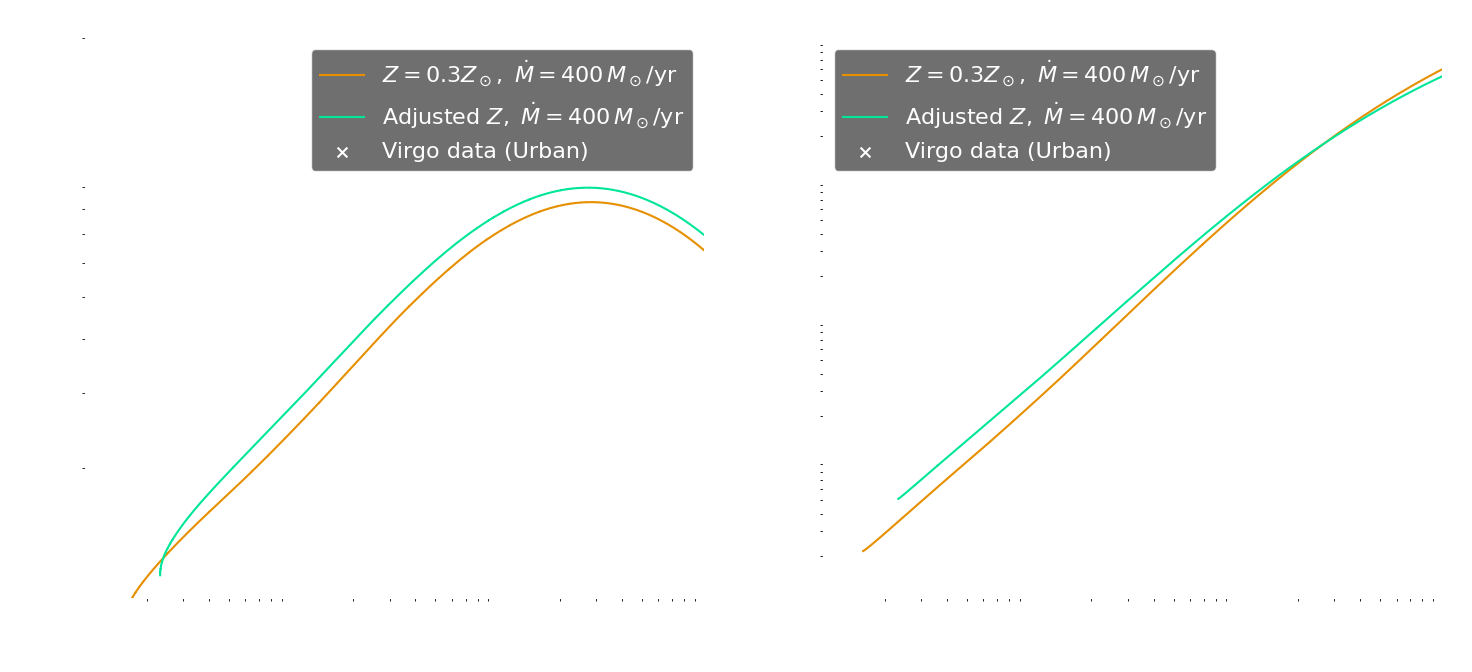

In [14]:
plt.rcParams.update({'font.size': 16})

runs = [
    (0.3, Mdot1 * 400),
    (-1,   Mdot1 * 400),
]

colors = ["#e69000", "#00e699"]
labels = [r"$Z = 0.3Z_\odot,\ \dot{M} = 400\,M_\odot/\mathrm{yr}$",
    r"$\mathrm{Adjusted}\ Z,\ \dot{M} = 400\,M_\odot/\mathrm{yr}$"]

results = []
for (Lambdatype, Mdot), label in zip(runs, labels):
    try:
        x, R0, v0, T0, recorder = BrentLooper(Mdot, 0.1 * ktc, 6 * ktc, Lambdatype)
        results.append((label, recorder))
    except Exception as e:
        print(f"Failed for {label}: {e}")

# --- Plot setup ---
fig, axes = plt.subplots(1, 2, figsize=(15, 7), sharex=True)

for (label, recorder), color in zip(results, colors):
    r_kpc = np.array(recorder["ra2"]) / ktc / 2339
    T     = np.array(recorder["Tarray"])
    rho   = np.array(recorder["rhoarray"])
    K     = (rho/mp_g)**(-2/3) * k_Bcgs * T * etkv

    axes[0].plot(r_kpc, T, color=color, label=label)
    axes[1].plot(r_kpc, K, color=color, label=label)

# --- Virgo data overlays in white ---
axes[0].scatter(r_vals, T_vals, s=50, marker='x', color='white', label='Virgo data (Urban)')
axes[1].scatter(r_vals2, K_vals, s=50, marker='x', color='white', label='Virgo data (Urban)')

# --- Formatting with white style ---
for ax, ylabel, title in zip(
    axes,
    ['Temperature (K)', 'Entropy (keV cm²)'],
    ['T vs Radius', 'K vs Radius']
):
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_xlabel(r'$r / r_{\mathrm{vir}}$', color='white')
    ax.set_ylabel(ylabel, color='white')
    ax.set_title(title, color='white')
    ax.set_xlim(1e-3, 1)
    ax.grid(True, which='both', ls='--', color='white', alpha=0.25)
    ax.tick_params(colors='white')
    
    for spine in ax.spines.values():
        spine.set_color('white')
    
    ax.set_facecolor('none')

# Axis bounds
axes[0].set_ylim(1e7, 2e8)
axes[1].set_ylim(1, 1e4)

# Legends
for ax in axes:
    legend = ax.legend()
    for text in legend.get_texts():
        text.set_color('#ffffff')
    legend.get_frame().set_edgecolor('#ffffff')
    legend.get_frame().set_facecolor('#404040')
    legend.get_frame().set_alpha(0.75)  # semi-transparent box

# Transparent figure background
fig.patch.set_alpha(0.0)

# Save as transparent PNG
plt.tight_layout()
plt.savefig("400Mdot.png", dpi=600, transparent=True)
plt.show()

c:\Users\Jacob\vscode library\lab_functions_1.py:137: RuntimeWarning: invalid value encountered in log10
  lvs = np.log10(vset)


x = 0.11303936695098878, Rsonic = 0.1 Mdot = 0.07075502459192691


c:\Users\Jacob\vscode library\lab_functions_1.py:137: RuntimeWarning: invalid value encountered in log10
  lvs = np.log10(vset)


x = 0.32044424987792963, Rsonic = 10.0 Mdot = 2577.2317665546702
x = 0.1380065355873108, Rsonic = 0.21497128969859158 Mdot = 0.5390474812983724
x = 0.322275302734375, Rsonic = 5.107485644849295 Mdot = 697.9322319730314
x = 0.30259148452758783, Rsonic = 2.661228467273944 Mdot = 200.88271789561804
x = 0.27436275299072266, Rsonic = 1.4380998784862677 Mdot = 61.01564237667519
x = 0.24247191574096677, Rsonic = 0.8265355840924297 Mdot = 18.984203555375046
x = 0.2597143301391601, Rsonic = 1.0919297243466815 Mdot = 34.89939494240665
x = 0.25513669799804684, Rsonic = 1.0102297512275673 Mdot = 29.53128890834649
x = 0.25513669799804684, Rsonic = 1.0102297512275673 Mdot = 29.53128890834649
x = 0.11303936695098878, Rsonic = 0.1 Mdot = 0.07075502459192691
x = 0.32044424987792963, Rsonic = 10.0 Mdot = 2577.2317665546702
x = 0.203714630279541, Rsonic = 0.48387183448394094 Mdot = 5.103328108331134
x = 0.3225804782104492, Rsonic = 5.24193591724197 Mdot = 733.6760306634279
x = 0.30549065155029287, Rsonic

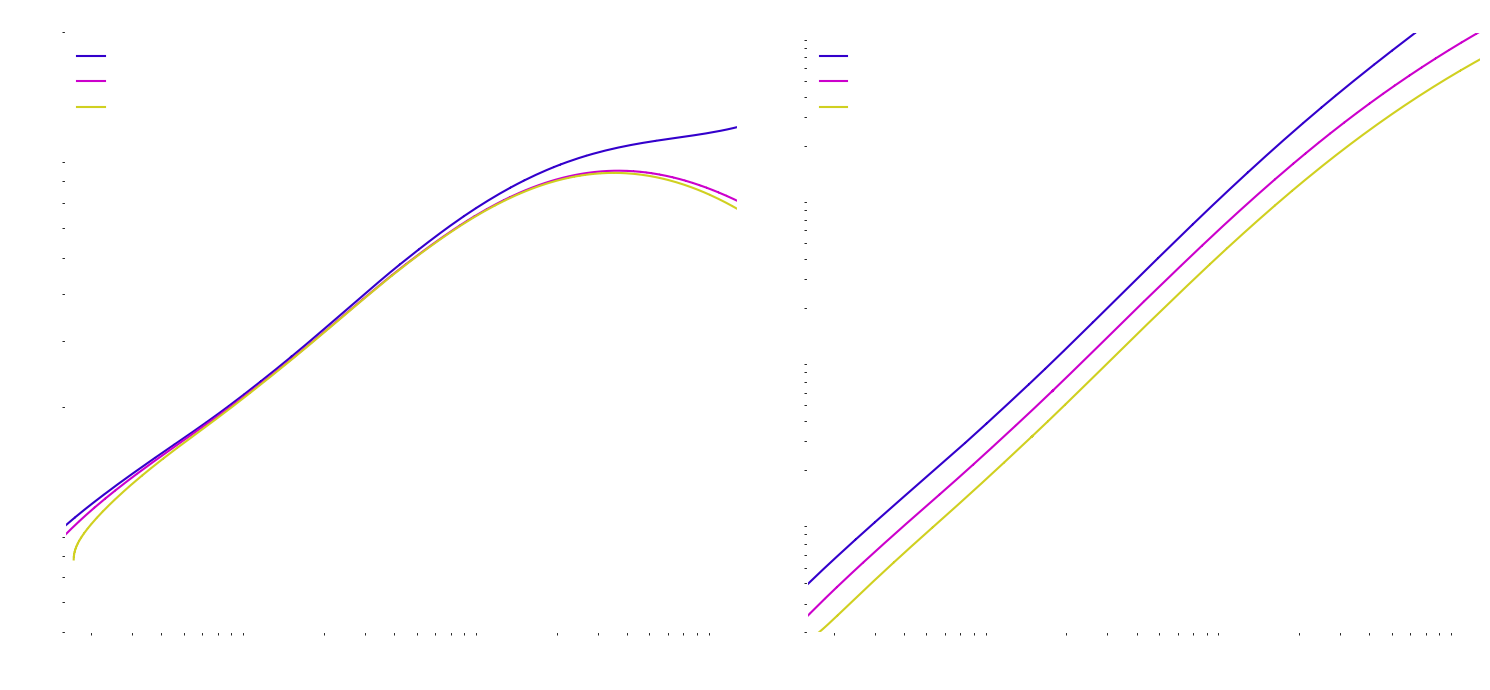

In [10]:
# --- User-defined inputs ---
mdot_values   = [30, 100, 300]
lambdatypes   = [0.3]
colors        = ["#3300cc", "#cc00cc", "#d0d020", "#00aa88", "#ffaa00"]
labels        = [rf"$\dot{{M}}={mdot}$" for mdot in mdot_values]

# --- Run simulations ---
results = []
for mdot in mdot_values:
    for Lambdatype in lambdatypes:
        try:
            x, R0, v0, T0, recorder = BrentLooper(mdot * Mdot1, 0.1 * ktc, 10 * ktc, Lambdatype)
            results.append((mdot, Lambdatype, recorder))
        except Exception as e:
            print(f"Failed for mdot={mdot}, Λ={Lambdatype}: {e}")

# --- Create subplots ---
fig, axes = plt.subplots(1, 2, figsize=(15, 7), sharex=True)

# --- Plot results ---
for (mdot, Lambdatype, recorder), color, label in zip(results, colors, labels):
    r_kpc = np.array(recorder["ra2"]) / ktc / 1954
    T     = np.array(recorder["Tarray"])
    rho   = np.array(recorder["rhoarray"])
    K     = (rho/mp_g)**(-2/3) * k_Bcgs * T * etkv

    axes[0].plot(r_kpc, T, color=color, label=label)
    axes[1].plot(r_kpc, K, color=color, label=label)

# --- Data overlays ---
axes[0].scatter(r_vals, T_vals, s=20, marker='x', color='white', label='Virgo data')
axes[1].scatter(r_vals2, K_vals, s=20, marker='x', color='white', label='Virgo data')

# --- Make everything white & transparent ---
for ax, ylabel, title in zip(
    axes,
    ['Temperature (K)', 'Entropy (keV cm²)'],
    ['T vs Radius', 'K vs Radius']
):
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_xlabel('r/rvir', color='white')
    ax.set_ylabel(ylabel, color='white')
    ax.set_title(title, color='white')
    ax.set_xlim(3/1954, 2340/1954)
    ax.grid(True, which='both', ls='--', color='white', alpha=0.3)
    ax.tick_params(colors='white')

    # Set spines to white
    for spine in ax.spines.values():
        spine.set_color('white')

    ax.set_facecolor('none')  # transparent axis background

    # Legend styling
    legend = ax.legend()
    for text in legend.get_texts():
        text.set_color('white')
    legend.get_frame().set_edgecolor('white')
    legend.get_frame().set_alpha(0.2)

# Axis limits
axes[0].set_ylim(5e6, 2e8)
axes[1].set_ylim(2, 1e4)

# Transparent figure background
fig.patch.set_alpha(0.0)

# Save
plt.tight_layout()
plt.savefig("mdotTKgraph.png", dpi=600, transparent=True)
plt.show()